# Simple q-learning agent with experience replay

We re-write q-learning algorithm using _agentnet_ - a helper for lasagne that implements some RL techniques.

In [1]:
! pip install --upgrade https://github.com/yandexdataschool/AgentNet/archive/master.zip

    100% |████████████████████████████████| 11.7MB 85kB/s eta 0:00:01
Requirement already up-to-date: six in /usr/local/lib/python2.7/site-packages (from agentnet==0.10.6)
Requirement already up-to-date: lasagne in /usr/local/lib/python2.7/site-packages (from agentnet==0.10.6)
Requirement already up-to-date: theano>=0.8.2 in /usr/local/lib/python2.7/site-packages (from agentnet==0.10.6)
Requirement already up-to-date: numpy>=1.9 in /usr/local/lib/python2.7/site-packages (from agentnet==0.10.6)
Requirement already up-to-date: scipy>=0.14 in /usr/local/lib/python2.7/site-packages (from theano>=0.8.2->agentnet==0.10.6)
  Found existing installation: agentnet 0.10.6
    Uninstalling agentnet-0.10.6:
      Successfully uninstalled agentnet-0.10.6
  Running setup.py install for agentnet ... - \ | done


In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
%env THEANO_FLAGS='floatX=float32'

#XVFB will be launched if you run on a server
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

env: THEANO_FLAGS='floatX=float32'


### Experiment setup
* Here we simply load the game and check that it works

In [2]:
import gym
make_env = lambda: gym.make("LunarLander-v2")

env=make_env()
env.reset()

state_shape = env.observation_space.shape
n_actions = env.action_space.n

[2018-02-02 23:29:21,208] Making new env: LunarLander-v2


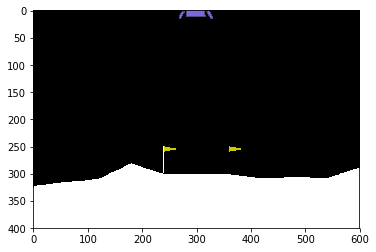

In [3]:
plt.imshow(env.render("rgb_array"))
del env

# Neural Network body

In [4]:
import lasagne
from lasagne.layers import *
from lasagne.nonlinearities import elu


#image observation at current tick goes here, shape = (sample_i,x,y,color)
observation_layer = InputLayer((None,)+state_shape)

layer = DenseLayer(observation_layer, 100, nonlinearity=elu)
layer = DenseLayer(layer, 200, nonlinearity=elu)

#a layer that predicts Qvalues
qvalues_layer = DenseLayer(layer,num_units=n_actions,
                           nonlinearity=None,name="q-values")

Picking actions is done by yet another layer, that implements $ \epsilon$ -greedy policy

In [5]:
from agentnet.resolver import EpsilonGreedyResolver
action_layer = EpsilonGreedyResolver(qvalues_layer)

#set starting epsilon
action_layer.epsilon.set_value(np.float32(0.05))


### Agent

We define an agent entirely composed of a lasagne network:
* Observations as InputLayer(s)
* Actions as intermediate Layer(s)
* `policy_estimators` is "whatever else you want to keep track of"

Each parameter can be either one layer or a list of layers

In [6]:
from agentnet.agent import Agent
agent = Agent(observation_layers=observation_layer,
              action_layers=action_layer,
              policy_estimators=qvalues_layer,)


In [7]:
#Since it's a single lasagne network, one can get it's weights, output, etc
weights = lasagne.layers.get_all_params(action_layer,trainable=True)
weights

[W, b, W, b, q-values.W, q-values.b]

# Create and manage a pool of atari sessions to play with

* To make training more stable, we shall have an entire batch of game sessions each happening independent of others
* Why several parallel agents help training: http://arxiv.org/pdf/1602.01783v1.pdf
* Alternative approach: store more sessions: https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

In [8]:
from agentnet.experiments.openai_gym.pool import EnvPool
pool = EnvPool(agent,make_env,n_games=1,max_size=10000)

[2018-02-02 23:30:31,702] Making new env: LunarLander-v2


In [9]:
%%time
#interact for 7 ticks
obs_log,action_log,reward_log,_,_,_  = pool.interact(5)


print('actions:',action_log)
print('rewards:',reward_log)

('actions:', array([[0, 0, 3, 0, 0]]))
('rewards:', array([[1.76360684, 1.88618985, 1.56593652, 1.7995859 , 0.        ]]))
CPU times: user 5.9 ms, sys: 3.68 ms, total: 9.58 ms
Wall time: 17.7 ms


In [10]:
#we'll train on rollouts of 10 steps (required by n-step algorithms and rnns later)
SEQ_LENGTH=10

#load first sessions (this function calls interact and stores sessions in the pool)

for _ in range(100):
    pool.update(SEQ_LENGTH)

# q-learning

We shall now define a function that replays recent game sessions and updates network weights

In [11]:
#get agent's Qvalues obtained via experience replay
replay = pool.experience_replay.sample_session_batch(100)
qvalues_seq = agent.get_sessions(
    replay,
    session_length=SEQ_LENGTH,
    experience_replay=True,
)[-1]



In [12]:
#loss for Qlearning = (Q(s,a) - (r+gamma*Q(s',a_max)))^2, like you implemented before in lasagne.

from agentnet.learning import qlearning
elwise_mse_loss = qlearning.get_elementwise_objective(qvalues_seq,
                                                      replay.actions[0],
                                                      replay.rewards,
                                                      replay.is_alive,
                                                      gamma_or_gammas=0.99,
                                                      n_steps=1,)

#compute mean loss over "alive" fragments
loss = elwise_mse_loss.sum() / replay.is_alive.sum()

In [13]:
#get weight updates
updates = lasagne.updates.adam(loss,weights,learning_rate=1e-4)

#compile train function
import theano
train_step = theano.function([],loss,updates=updates)

# Demo run

Play full session with an untrained agent

In [14]:
#for MountainCar-v0 evaluation session is cropped to 200 ticks
untrained_reward = pool.evaluate(save_path="./records",record_video=True)

[2018-02-02 23:31:56,944] Making new env: LunarLander-v2
[2018-02-02 23:31:56,955] Creating monitor directory ./records
[2018-02-02 23:31:56,959] Starting new video recorder writing to /Users/maximdankovtsev/Developer/ml-mipt-part2/hw/HW5/records/openaigym.video.0.2487.video000000.mp4
[2018-02-02 23:31:58,797] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maximdankovtsev/Developer/ml-mipt-part2/hw/HW5/records')


Episode finished after 85 timesteps with reward=-487.614407234


In [15]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./records/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./records/"+video_names[-1])) #this may or may not be _last_ video. Try other indices

# Training loop

In [16]:
epoch_counter = 1 #starting epoch
rewards = {} #full game rewards
target_score = -90

In [17]:
from tqdm import trange

for i in trange(10000):    
    
    #play
    for _ in range(5):
        pool.update(SEQ_LENGTH,append=True)
    
    #train
    train_step()
    
    #update epsilon
    epsilon = 0.05 + 0.95*np.exp(-epoch_counter/1000.)
    action_layer.epsilon.set_value(np.float32(epsilon))
    
    #play a few games for evaluation
    if epoch_counter%100==0:
        rewards[epoch_counter] = np.mean(pool.evaluate(n_games=3,record_video=False))
        print("iter=%i\tepsilon=%.3f"%(epoch_counter,action_layer.epsilon.get_value(),))
        print("Current score(mean over %i) = %.3f"%(3,np.mean(rewards[epoch_counter])))
    
        if rewards[epoch_counter] >= target_score:
            print("You win!")
            break

    
    epoch_counter  +=1

    
# Time to drink some coffee!

  1%|          | 98/10000 [00:03<06:44, 24.50it/s][2018-02-02 23:33:44,841] Making new env: LunarLander-v2
[2018-02-02 23:33:44,848] Clearing 4 monitor files from previous run (because force=True was provided)
[2018-02-02 23:33:44,976] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maximdankovtsev/Developer/ml-mipt-part2/hw/HW5/records')
  1%|          | 100/10000 [00:04<06:57, 23.70it/s]

Episode finished after 104 timesteps with reward=-296.954534809
Episode finished after 65 timesteps with reward=-121.228915335
Episode finished after 88 timesteps with reward=-87.1448991751
iter=100	epsilon=0.910
Current score(mean over 3) = -168.443


  2%|▏         | 199/10000 [00:08<06:46, 24.10it/s][2018-02-02 23:33:49,068] Making new env: LunarLander-v2
[2018-02-02 23:33:49,079] Clearing 2 monitor files from previous run (because force=True was provided)
[2018-02-02 23:33:49,249] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maximdankovtsev/Developer/ml-mipt-part2/hw/HW5/records')


Episode finished after 77 timesteps with reward=-103.249217352
Episode finished after 121 timesteps with reward=-390.633116471
Episode finished after 118 timesteps with reward=-506.985277236
iter=200	epsilon=0.828
Current score(mean over 3) = -333.623


  3%|▎         | 298/10000 [00:12<07:02, 22.96it/s][2018-02-02 23:33:53,830] Making new env: LunarLander-v2
[2018-02-02 23:33:53,840] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 188 timesteps with reward=-326.925074313


[2018-02-02 23:33:55,436] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maximdankovtsev/Developer/ml-mipt-part2/hw/HW5/records')
  3%|▎         | 301/10000 [00:14<07:54, 20.44it/s]

Episode finished after 1000 timesteps with reward=15.5409240645
Episode finished after 89 timesteps with reward=-304.960264375
iter=300	epsilon=0.754
Current score(mean over 3) = -205.448


  4%|▍         | 397/10000 [00:19<07:40, 20.84it/s][2018-02-02 23:33:59,978] Making new env: LunarLander-v2
[2018-02-02 23:33:59,987] Clearing 2 monitor files from previous run (because force=True was provided)
[2018-02-02 23:34:00,274] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maximdankovtsev/Developer/ml-mipt-part2/hw/HW5/records')


Episode finished after 131 timesteps with reward=-421.826865106
Episode finished after 88 timesteps with reward=-250.829689356
Episode finished after 242 timesteps with reward=-232.663551697


  4%|▍         | 403/10000 [00:19<07:48, 20.50it/s]

iter=400	epsilon=0.687
Current score(mean over 3) = -301.773


  5%|▍         | 498/10000 [00:24<07:45, 20.43it/s][2018-02-02 23:34:05,253] Making new env: LunarLander-v2
[2018-02-02 23:34:05,261] Clearing 2 monitor files from previous run (because force=True was provided)
[2018-02-02 23:34:05,450] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maximdankovtsev/Developer/ml-mipt-part2/hw/HW5/records')
  5%|▌         | 501/10000 [00:24<07:49, 20.25it/s]

Episode finished after 121 timesteps with reward=-204.572037941
Episode finished after 140 timesteps with reward=-395.065651293
Episode finished after 75 timesteps with reward=-416.815749015
iter=500	epsilon=0.626
Current score(mean over 3) = -338.818


  6%|▌         | 598/10000 [00:29<07:46, 20.14it/s][2018-02-02 23:34:10,573] Making new env: LunarLander-v2
[2018-02-02 23:34:10,583] Clearing 2 monitor files from previous run (because force=True was provided)
[2018-02-02 23:34:10,814] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maximdankovtsev/Developer/ml-mipt-part2/hw/HW5/records')


Episode finished after 107 timesteps with reward=-380.209481372
Episode finished after 160 timesteps with reward=-541.872990116
Episode finished after 148 timesteps with reward=-290.126998534
iter=600	epsilon=0.571
Current score(mean over 3) = -404.070


  7%|▋         | 699/10000 [00:35<07:47, 19.88it/s][2018-02-02 23:34:15,965] Making new env: LunarLander-v2
[2018-02-02 23:34:15,972] Clearing 2 monitor files from previous run (because force=True was provided)
[2018-02-02 23:34:16,136] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maximdankovtsev/Developer/ml-mipt-part2/hw/HW5/records')
  7%|▋         | 701/10000 [00:35<07:50, 19.78it/s]

Episode finished after 83 timesteps with reward=-368.671879627
Episode finished after 144 timesteps with reward=-410.943652793
Episode finished after 82 timesteps with reward=-333.940591041
iter=700	epsilon=0.522
Current score(mean over 3) = -371.185


  8%|▊         | 799/10000 [00:41<08:02, 19.06it/s][2018-02-02 23:34:22,728] Making new env: LunarLander-v2
[2018-02-02 23:34:22,736] Clearing 2 monitor files from previous run (because force=True was provided)
[2018-02-02 23:34:22,919] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maximdankovtsev/Developer/ml-mipt-part2/hw/HW5/records')
  8%|▊         | 801/10000 [00:42<08:04, 18.98it/s]

Episode finished after 130 timesteps with reward=-573.74642093
Episode finished after 116 timesteps with reward=-419.612215351
Episode finished after 131 timesteps with reward=-265.03225093
iter=800	epsilon=0.477
Current score(mean over 3) = -419.464


  9%|▉         | 899/10000 [00:47<08:02, 18.86it/s][2018-02-02 23:34:28,483] Making new env: LunarLander-v2
[2018-02-02 23:34:28,492] Clearing 2 monitor files from previous run (because force=True was provided)
[2018-02-02 23:34:28,634] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maximdankovtsev/Developer/ml-mipt-part2/hw/HW5/records')
  9%|▉         | 901/10000 [00:47<08:04, 18.80it/s]

Episode finished after 98 timesteps with reward=-489.2086515
Episode finished after 110 timesteps with reward=-488.48554717
Episode finished after 90 timesteps with reward=-158.190433033
iter=900	epsilon=0.436
Current score(mean over 3) = -378.628


 10%|▉         | 999/10000 [00:54<08:11, 18.32it/s][2018-02-02 23:34:35,440] Making new env: LunarLander-v2
[2018-02-02 23:34:35,448] Clearing 2 monitor files from previous run (because force=True was provided)
[2018-02-02 23:34:35,790] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maximdankovtsev/Developer/ml-mipt-part2/hw/HW5/records')
 10%|█         | 1000/10000 [00:55<08:15, 18.17it/s]

Episode finished after 288 timesteps with reward=-815.596200816
Episode finished after 138 timesteps with reward=-652.353391355
Episode finished after 101 timesteps with reward=-246.900702215
iter=1000	epsilon=0.399
Current score(mean over 3) = -571.617


 11%|█         | 1099/10000 [01:01<08:20, 17.78it/s][2018-02-02 23:34:42,618] Making new env: LunarLander-v2
[2018-02-02 23:34:42,625] Clearing 2 monitor files from previous run (because force=True was provided)
[2018-02-02 23:34:42,790] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maximdankovtsev/Developer/ml-mipt-part2/hw/HW5/records')
 11%|█         | 1101/10000 [01:02<08:21, 17.73it/s]

Episode finished after 89 timesteps with reward=-292.663124075
Episode finished after 94 timesteps with reward=-395.590120238
Episode finished after 128 timesteps with reward=-570.103040297
iter=1100	epsilon=0.366
Current score(mean over 3) = -419.452


 12%|█▏        | 1199/10000 [01:07<08:18, 17.64it/s][2018-02-02 23:34:48,782] Making new env: LunarLander-v2
[2018-02-02 23:34:48,790] Clearing 2 monitor files from previous run (because force=True was provided)
[2018-02-02 23:34:49,133] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maximdankovtsev/Developer/ml-mipt-part2/hw/HW5/records')


Episode finished after 218 timesteps with reward=-620.317006863
Episode finished after 155 timesteps with reward=-703.212498827
Episode finished after 92 timesteps with reward=-312.375760642
iter=1200	epsilon=0.336
Current score(mean over 3) = -545.302


 13%|█▎        | 1299/10000 [01:14<08:18, 17.44it/s][2018-02-02 23:34:55,313] Making new env: LunarLander-v2
[2018-02-02 23:34:55,321] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 363 timesteps with reward=-899.085426349
Episode finished after 173 timesteps with reward=-601.110787917


[2018-02-02 23:34:55,843] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maximdankovtsev/Developer/ml-mipt-part2/hw/HW5/records')
 13%|█▎        | 1303/10000 [01:15<08:22, 17.31it/s]

Episode finished after 195 timesteps with reward=-393.858745726
iter=1300	epsilon=0.309
Current score(mean over 3) = -631.352


 14%|█▍        | 1399/10000 [01:21<08:23, 17.08it/s][2018-02-02 23:35:02,728] Making new env: LunarLander-v2
[2018-02-02 23:35:02,736] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 182 timesteps with reward=-294.653449894
Episode finished after 224 timesteps with reward=-450.72139049


[2018-02-02 23:35:03,186] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maximdankovtsev/Developer/ml-mipt-part2/hw/HW5/records')
 14%|█▍        | 1401/10000 [01:22<08:26, 16.98it/s]

Episode finished after 246 timesteps with reward=-844.780504017
iter=1400	epsilon=0.284
Current score(mean over 3) = -530.052


 15%|█▍        | 1498/10000 [01:30<08:34, 16.53it/s][2018-02-02 23:35:11,493] Making new env: LunarLander-v2
[2018-02-02 23:35:11,501] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 267 timesteps with reward=-504.182885251
Episode finished after 225 timesteps with reward=-404.088339539


[2018-02-02 23:35:11,957] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maximdankovtsev/Developer/ml-mipt-part2/hw/HW5/records')
 15%|█▌        | 1502/10000 [01:31<08:36, 16.44it/s]

Episode finished after 194 timesteps with reward=-413.243130891
iter=1500	epsilon=0.262
Current score(mean over 3) = -440.505


 16%|█▌        | 1598/10000 [01:39<08:45, 15.99it/s][2018-02-02 23:35:20,834] Making new env: LunarLander-v2
[2018-02-02 23:35:20,842] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 273 timesteps with reward=-654.11767959
Episode finished after 191 timesteps with reward=-710.839784632


[2018-02-02 23:35:21,259] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maximdankovtsev/Developer/ml-mipt-part2/hw/HW5/records')
 16%|█▌        | 1602/10000 [01:40<08:47, 15.92it/s]

Episode finished after 210 timesteps with reward=-322.907646717
iter=1600	epsilon=0.242
Current score(mean over 3) = -562.622


 17%|█▋        | 1699/10000 [01:48<08:51, 15.62it/s][2018-02-02 23:35:29,634] Making new env: LunarLander-v2
[2018-02-02 23:35:29,642] Clearing 2 monitor files from previous run (because force=True was provided)
[2018-02-02 23:35:29,788] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maximdankovtsev/Developer/ml-mipt-part2/hw/HW5/records')
 17%|█▋        | 1701/10000 [01:49<08:52, 15.59it/s]

Episode finished after 88 timesteps with reward=-285.143418162
Episode finished after 84 timesteps with reward=-389.436132983
Episode finished after 97 timesteps with reward=-166.538499894
iter=1700	epsilon=0.224
Current score(mean over 3) = -280.373


 18%|█▊        | 1799/10000 [01:56<08:53, 15.38it/s][2018-02-02 23:35:37,814] Making new env: LunarLander-v2
[2018-02-02 23:35:37,823] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 108 timesteps with reward=-200.459412965
Episode finished after 190 timesteps with reward=-245.504469089


[2018-02-02 23:35:38,677] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maximdankovtsev/Developer/ml-mipt-part2/hw/HW5/records')
 18%|█▊        | 1801/10000 [01:58<08:57, 15.26it/s]

Episode finished after 600 timesteps with reward=-433.012754558
iter=1800	epsilon=0.207
Current score(mean over 3) = -292.992


 19%|█▉        | 1898/10000 [02:06<09:01, 14.95it/s][2018-02-02 23:35:47,919] Making new env: LunarLander-v2
[2018-02-02 23:35:47,928] Clearing 2 monitor files from previous run (because force=True was provided)
[2018-02-02 23:35:48,136] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maximdankovtsev/Developer/ml-mipt-part2/hw/HW5/records')
 19%|█▉        | 1900/10000 [02:07<09:03, 14.92it/s]

Episode finished after 195 timesteps with reward=-171.1125644
Episode finished after 88 timesteps with reward=-103.526850895
Episode finished after 87 timesteps with reward=-123.329594364
iter=1900	epsilon=0.192
Current score(mean over 3) = -132.656


 20%|█▉        | 1999/10000 [02:16<09:05, 14.66it/s][2018-02-02 23:35:57,244] Making new env: LunarLander-v2
[2018-02-02 23:35:57,252] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 131 timesteps with reward=-116.372554217
Episode finished after 234 timesteps with reward=-325.674257251


[2018-02-02 23:35:57,666] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maximdankovtsev/Developer/ml-mipt-part2/hw/HW5/records')
 20%|██        | 2001/10000 [02:17<09:07, 14.60it/s]

Episode finished after 244 timesteps with reward=-327.594565664
iter=2000	epsilon=0.179
Current score(mean over 3) = -256.547


 21%|██        | 2099/10000 [02:25<09:08, 14.40it/s][2018-02-02 23:36:06,633] Making new env: LunarLander-v2
[2018-02-02 23:36:06,641] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 286 timesteps with reward=-261.999056175
Episode finished after 436 timesteps with reward=-270.97476425


[2018-02-02 23:36:07,787] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maximdankovtsev/Developer/ml-mipt-part2/hw/HW5/records')
 21%|██        | 2101/10000 [02:27<09:13, 14.28it/s]

Episode finished after 357 timesteps with reward=-287.442293338
iter=2100	epsilon=0.166
Current score(mean over 3) = -273.472


 22%|██▏       | 2198/10000 [02:37<09:20, 13.93it/s][2018-02-02 23:36:18,753] Making new env: LunarLander-v2
[2018-02-02 23:36:18,761] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 413 timesteps with reward=-422.570678065
Episode finished after 216 timesteps with reward=-212.312706279


[2018-02-02 23:36:19,376] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maximdankovtsev/Developer/ml-mipt-part2/hw/HW5/records')
 22%|██▏       | 2200/10000 [02:38<09:22, 13.87it/s]

Episode finished after 236 timesteps with reward=-255.349857964
iter=2200	epsilon=0.155
Current score(mean over 3) = -296.744


 23%|██▎       | 2299/10000 [02:47<09:20, 13.75it/s][2018-02-02 23:36:28,047] Making new env: LunarLander-v2
[2018-02-02 23:36:28,055] Clearing 2 monitor files from previous run (because force=True was provided)
[2018-02-02 23:36:28,212] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maximdankovtsev/Developer/ml-mipt-part2/hw/HW5/records')
 23%|██▎       | 2301/10000 [02:47<09:20, 13.73it/s]

Episode finished after 98 timesteps with reward=-224.321503825
Episode finished after 99 timesteps with reward=-194.857557267
Episode finished after 90 timesteps with reward=-444.546613334
iter=2300	epsilon=0.145
Current score(mean over 3) = -287.909


 24%|██▍       | 2399/10000 [02:55<09:15, 13.68it/s][2018-02-02 23:36:36,165] Making new env: LunarLander-v2
[2018-02-02 23:36:36,173] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 147 timesteps with reward=-294.274681352
Episode finished after 198 timesteps with reward=-178.371209142


[2018-02-02 23:36:36,703] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maximdankovtsev/Developer/ml-mipt-part2/hw/HW5/records')
 24%|██▍       | 2401/10000 [02:56<09:17, 13.64it/s]

Episode finished after 356 timesteps with reward=-342.24390786
iter=2400	epsilon=0.136
Current score(mean over 3) = -271.630


 25%|██▍       | 2499/10000 [03:04<09:13, 13.56it/s][2018-02-02 23:36:45,104] Making new env: LunarLander-v2
[2018-02-02 23:36:45,112] Clearing 2 monitor files from previous run (because force=True was provided)
[2018-02-02 23:36:45,264] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maximdankovtsev/Developer/ml-mipt-part2/hw/HW5/records')
 25%|██▌       | 2501/10000 [03:04<09:13, 13.55it/s]

Episode finished after 95 timesteps with reward=-301.225929812
Episode finished after 106 timesteps with reward=-213.483925081
Episode finished after 93 timesteps with reward=-395.410927677
iter=2500	epsilon=0.128
Current score(mean over 3) = -303.374


 26%|██▌       | 2598/10000 [03:12<09:09, 13.48it/s][2018-02-02 23:36:53,665] Making new env: LunarLander-v2
[2018-02-02 23:36:53,672] Clearing 2 monitor files from previous run (because force=True was provided)
[2018-02-02 23:36:53,914] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maximdankovtsev/Developer/ml-mipt-part2/hw/HW5/records')
 26%|██▌       | 2600/10000 [03:13<09:09, 13.46it/s]

Episode finished after 85 timesteps with reward=-238.805244836
Episode finished after 79 timesteps with reward=-488.117388331
Episode finished after 237 timesteps with reward=-265.210691682
iter=2600	epsilon=0.121
Current score(mean over 3) = -330.711


 27%|██▋       | 2698/10000 [03:21<09:04, 13.41it/s][2018-02-02 23:37:02,099] Making new env: LunarLander-v2
[2018-02-02 23:37:02,106] Clearing 2 monitor files from previous run (because force=True was provided)
[2018-02-02 23:37:02,300] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maximdankovtsev/Developer/ml-mipt-part2/hw/HW5/records')
 27%|██▋       | 2700/10000 [03:21<09:04, 13.40it/s]

Episode finished after 142 timesteps with reward=-472.721042044
Episode finished after 90 timesteps with reward=-572.39416577
Episode finished after 102 timesteps with reward=-74.1486881188
iter=2700	epsilon=0.114
Current score(mean over 3) = -373.088


 28%|██▊       | 2798/10000 [03:29<08:58, 13.36it/s][2018-02-02 23:37:10,325] Making new env: LunarLander-v2
[2018-02-02 23:37:10,333] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 199 timesteps with reward=-409.595820422
Episode finished after 201 timesteps with reward=-322.63308869


[2018-02-02 23:37:10,679] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maximdankovtsev/Developer/ml-mipt-part2/hw/HW5/records')
 28%|██▊       | 2802/10000 [03:30<08:59, 13.34it/s]

Episode finished after 149 timesteps with reward=-355.763015427
iter=2800	epsilon=0.108
Current score(mean over 3) = -362.664


 29%|██▉       | 2898/10000 [03:38<08:54, 13.29it/s][2018-02-02 23:37:19,014] Making new env: LunarLander-v2
[2018-02-02 23:37:19,023] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 292 timesteps with reward=-595.400554235
Episode finished after 136 timesteps with reward=-61.246122753


[2018-02-02 23:37:19,481] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maximdankovtsev/Developer/ml-mipt-part2/hw/HW5/records')
 29%|██▉       | 2902/10000 [03:38<08:55, 13.26it/s]

Episode finished after 146 timesteps with reward=-335.528327487
iter=2900	epsilon=0.102
Current score(mean over 3) = -330.725


 30%|██▉       | 2998/10000 [03:47<08:51, 13.18it/s][2018-02-02 23:37:28,450] Making new env: LunarLander-v2
[2018-02-02 23:37:28,457] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 191 timesteps with reward=-389.976319169
Episode finished after 167 timesteps with reward=-386.538233867


[2018-02-02 23:37:28,863] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maximdankovtsev/Developer/ml-mipt-part2/hw/HW5/records')
 30%|███       | 3002/10000 [03:48<08:52, 13.15it/s]

Episode finished after 194 timesteps with reward=-502.207735779
iter=3000	epsilon=0.097
Current score(mean over 3) = -426.241


 31%|███       | 3099/10000 [03:57<08:48, 13.07it/s][2018-02-02 23:37:38,017] Making new env: LunarLander-v2
[2018-02-02 23:37:38,026] Clearing 2 monitor files from previous run (because force=True was provided)
[2018-02-02 23:37:38,644] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maximdankovtsev/Developer/ml-mipt-part2/hw/HW5/records')


Episode finished after 433 timesteps with reward=-178.075120832
Episode finished after 126 timesteps with reward=-35.1388364804
Episode finished after 182 timesteps with reward=-212.888124684
iter=3100	epsilon=0.093
Current score(mean over 3) = -142.034

 32%|███▏      | 3198/10000 [04:09<08:50, 12.83it/s][2018-02-02 23:37:50,246] Making new env: LunarLander-v2
[2018-02-02 23:37:50,259] Clearing 2 monitor files from previous run (because force=True was provided)



Episode finished after 312 timesteps with reward=-252.672233876


[2018-02-02 23:37:51,089] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maximdankovtsev/Developer/ml-mipt-part2/hw/HW5/records')
 32%|███▏      | 3200/10000 [04:10<08:51, 12.78it/s]

Episode finished after 285 timesteps with reward=-246.197518434
Episode finished after 231 timesteps with reward=-369.434337547
iter=3200	epsilon=0.089
Current score(mean over 3) = -289.435


 33%|███▎      | 3299/10000 [04:20<08:49, 12.66it/s][2018-02-02 23:38:01,448] Making new env: LunarLander-v2
[2018-02-02 23:38:01,456] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 255 timesteps with reward=-106.784491238
Episode finished after 112 timesteps with reward=-181.703249911


[2018-02-02 23:38:01,881] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maximdankovtsev/Developer/ml-mipt-part2/hw/HW5/records')
 33%|███▎      | 3301/10000 [04:21<08:50, 12.64it/s]

Episode finished after 191 timesteps with reward=-201.694291487
iter=3300	epsilon=0.085
Current score(mean over 3) = -163.394


 34%|███▍      | 3399/10000 [04:34<08:53, 12.38it/s][2018-02-02 23:38:15,418] Making new env: LunarLander-v2
[2018-02-02 23:38:15,427] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 318 timesteps with reward=-160.708972021
Episode finished after 400 timesteps with reward=-350.666948382


[2018-02-02 23:38:16,384] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maximdankovtsev/Developer/ml-mipt-part2/hw/HW5/records')
 34%|███▍      | 3402/10000 [04:35<08:54, 12.34it/s]

Episode finished after 300 timesteps with reward=-152.438088919
iter=3400	epsilon=0.082
Current score(mean over 3) = -221.271


 35%|███▍      | 3499/10000 [04:45<08:50, 12.27it/s][2018-02-02 23:38:26,106] Making new env: LunarLander-v2
[2018-02-02 23:38:26,115] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 82 timesteps with reward=-260.914102106
Episode finished after 256 timesteps with reward=-379.887246279


[2018-02-02 23:38:26,468] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maximdankovtsev/Developer/ml-mipt-part2/hw/HW5/records')
 35%|███▌      | 3501/10000 [04:45<08:50, 12.25it/s]

Episode finished after 194 timesteps with reward=-380.274633323
iter=3500	epsilon=0.079
Current score(mean over 3) = -340.359


 36%|███▌      | 3598/10000 [04:55<08:46, 12.16it/s][2018-02-02 23:38:36,787] Making new env: LunarLander-v2
[2018-02-02 23:38:36,797] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 267 timesteps with reward=-368.507173407
Episode finished after 250 timesteps with reward=-356.232059223


[2018-02-02 23:38:38,285] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maximdankovtsev/Developer/ml-mipt-part2/hw/HW5/records')
 36%|███▌      | 3601/10000 [04:57<08:48, 12.10it/s]

Episode finished after 617 timesteps with reward=-396.794148267
iter=3600	epsilon=0.076
Current score(mean over 3) = -373.844


 37%|███▋      | 3699/10000 [05:06<08:42, 12.06it/s][2018-02-02 23:38:47,665] Making new env: LunarLander-v2
[2018-02-02 23:38:47,673] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 278 timesteps with reward=-452.00340381
Episode finished after 289 timesteps with reward=-333.222452133


[2018-02-02 23:38:48,396] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maximdankovtsev/Developer/ml-mipt-part2/hw/HW5/records')
 37%|███▋      | 3702/10000 [05:07<08:43, 12.03it/s]

Episode finished after 271 timesteps with reward=-389.390741332
iter=3700	epsilon=0.073
Current score(mean over 3) = -391.539


 38%|███▊      | 3799/10000 [05:17<08:37, 11.98it/s][2018-02-02 23:38:57,877] Making new env: LunarLander-v2
[2018-02-02 23:38:57,885] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 247 timesteps with reward=-229.708186429
Episode finished after 206 timesteps with reward=-62.442274723


[2018-02-02 23:38:58,302] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maximdankovtsev/Developer/ml-mipt-part2/hw/HW5/records')
 38%|███▊      | 3801/10000 [05:17<08:38, 11.97it/s]

Episode finished after 125 timesteps with reward=-397.465580018
iter=3800	epsilon=0.071
Current score(mean over 3) = -229.872


 39%|███▉      | 3898/10000 [05:26<08:31, 11.92it/s][2018-02-02 23:39:07,834] Making new env: LunarLander-v2
[2018-02-02 23:39:07,842] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 164 timesteps with reward=-256.96949133
Episode finished after 315 timesteps with reward=-395.954009847


[2018-02-02 23:39:08,668] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maximdankovtsev/Developer/ml-mipt-part2/hw/HW5/records')
 39%|███▉      | 3901/10000 [05:28<08:32, 11.89it/s]

Episode finished after 378 timesteps with reward=-344.416611004
iter=3900	epsilon=0.069
Current score(mean over 3) = -332.447


 40%|███▉      | 3998/10000 [05:38<08:27, 11.83it/s][2018-02-02 23:39:19,036] Making new env: LunarLander-v2
[2018-02-02 23:39:19,044] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 196 timesteps with reward=-36.6738408823
Episode finished after 197 timesteps with reward=-238.412346762


[2018-02-02 23:39:19,459] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maximdankovtsev/Developer/ml-mipt-part2/hw/HW5/records')
 40%|████      | 4001/10000 [05:38<08:27, 11.81it/s]

Episode finished after 196 timesteps with reward=-290.042565029
iter=4000	epsilon=0.067
Current score(mean over 3) = -188.376


 41%|████      | 4099/10000 [05:47<08:20, 11.78it/s][2018-02-02 23:39:28,723] Making new env: LunarLander-v2
[2018-02-02 23:39:28,731] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 148 timesteps with reward=-535.393065578
Episode finished after 119 timesteps with reward=-483.325736172


[2018-02-02 23:39:29,089] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maximdankovtsev/Developer/ml-mipt-part2/hw/HW5/records')
 41%|████      | 4101/10000 [05:48<08:21, 11.77it/s]

Episode finished after 261 timesteps with reward=-400.967557411
iter=4100	epsilon=0.066
Current score(mean over 3) = -473.229


 42%|████▏     | 4199/10000 [05:56<08:13, 11.76it/s][2018-02-02 23:39:37,796] Making new env: LunarLander-v2
[2018-02-02 23:39:37,804] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 246 timesteps with reward=-301.743806413
Episode finished after 194 timesteps with reward=-47.0714958834


[2018-02-02 23:39:38,261] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maximdankovtsev/Developer/ml-mipt-part2/hw/HW5/records')
 42%|████▏     | 4201/10000 [05:57<08:13, 11.75it/s]

Episode finished after 207 timesteps with reward=-270.77348585
iter=4200	epsilon=0.064
Current score(mean over 3) = -206.530


 43%|████▎     | 4299/10000 [06:06<08:06, 11.72it/s][2018-02-02 23:39:47,699] Making new env: LunarLander-v2
[2018-02-02 23:39:47,707] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 241 timesteps with reward=-238.320905235
Episode finished after 192 timesteps with reward=-206.32618071


[2018-02-02 23:39:48,131] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maximdankovtsev/Developer/ml-mipt-part2/hw/HW5/records')
 43%|████▎     | 4302/10000 [06:07<08:06, 11.71it/s]

Episode finished after 165 timesteps with reward=-183.608123963
iter=4300	epsilon=0.063
Current score(mean over 3) = -209.418


 44%|████▍     | 4399/10000 [06:17<08:01, 11.64it/s][2018-02-02 23:39:58,796] Making new env: LunarLander-v2
[2018-02-02 23:39:58,806] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 109 timesteps with reward=-120.325620058
Episode finished after 222 timesteps with reward=-216.697055264


[2018-02-02 23:39:59,164] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maximdankovtsev/Developer/ml-mipt-part2/hw/HW5/records')
 44%|████▍     | 4401/10000 [06:18<08:01, 11.63it/s]

Episode finished after 152 timesteps with reward=-212.150742795
iter=4400	epsilon=0.062
Current score(mean over 3) = -183.058


 45%|████▍     | 4499/10000 [06:28<07:54, 11.59it/s][2018-02-02 23:40:09,145] Making new env: LunarLander-v2
[2018-02-02 23:40:09,155] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 150 timesteps with reward=-205.788729623
Episode finished after 178 timesteps with reward=-23.803507788


[2018-02-02 23:40:09,552] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maximdankovtsev/Developer/ml-mipt-part2/hw/HW5/records')
 45%|████▌     | 4501/10000 [06:28<07:55, 11.57it/s]

Episode finished after 96 timesteps with reward=-177.833124466
iter=4500	epsilon=0.061
Current score(mean over 3) = -135.808


 46%|████▌     | 4599/10000 [06:38<07:48, 11.54it/s][2018-02-02 23:40:19,489] Making new env: LunarLander-v2
[2018-02-02 23:40:19,497] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 240 timesteps with reward=-61.4090859326
Episode finished after 197 timesteps with reward=-160.916759659


[2018-02-02 23:40:20,000] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maximdankovtsev/Developer/ml-mipt-part2/hw/HW5/records')
 46%|████▌     | 4601/10000 [06:39<07:48, 11.52it/s]

Episode finished after 220 timesteps with reward=-230.119623404
iter=4600	epsilon=0.060
Current score(mean over 3) = -150.815


 47%|████▋     | 4699/10000 [06:49<07:41, 11.49it/s][2018-02-02 23:40:29,920] Making new env: LunarLander-v2
[2018-02-02 23:40:29,928] Clearing 2 monitor files from previous run (because force=True was provided)
[2018-02-02 23:40:30,191] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maximdankovtsev/Developer/ml-mipt-part2/hw/HW5/records')


Episode finished after 179 timesteps with reward=-220.577432665
Episode finished after 97 timesteps with reward=-343.476989323
Episode finished after 167 timesteps with reward=-135.922883282
iter=4700	epsilon=0.059
Current score(mean over 3) = -233.326


 48%|████▊     | 4798/10000 [06:57<07:33, 11.48it/s][2018-02-02 23:40:38,798] Making new env: LunarLander-v2
[2018-02-02 23:40:38,806] Clearing 2 monitor files from previous run (because force=True was provided)
[2018-02-02 23:40:39,035] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maximdankovtsev/Developer/ml-mipt-part2/hw/HW5/records')
 48%|████▊     | 4800/10000 [06:58<07:33, 11.48it/s]

Episode finished after 85 timesteps with reward=-712.755718712
Episode finished after 177 timesteps with reward=-249.13621452
Episode finished after 139 timesteps with reward=-297.825778718
iter=4800	epsilon=0.058
Current score(mean over 3) = -419.906


 49%|████▉     | 4898/10000 [07:06<07:24, 11.49it/s][2018-02-02 23:40:47,273] Making new env: LunarLander-v2
[2018-02-02 23:40:47,282] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 96 timesteps with reward=-336.603246816
Episode finished after 208 timesteps with reward=-172.336220285


[2018-02-02 23:40:47,661] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maximdankovtsev/Developer/ml-mipt-part2/hw/HW5/records')
 49%|████▉     | 4902/10000 [07:07<07:24, 11.48it/s]

Episode finished after 269 timesteps with reward=-263.093812226
iter=4900	epsilon=0.057
Current score(mean over 3) = -257.344


 50%|████▉     | 4999/10000 [07:15<07:15, 11.49it/s][2018-02-02 23:40:55,945] Making new env: LunarLander-v2
[2018-02-02 23:40:55,953] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 164 timesteps with reward=-245.506770323
Episode finished after 81 timesteps with reward=-573.45081769


[2018-02-02 23:40:56,290] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maximdankovtsev/Developer/ml-mipt-part2/hw/HW5/records')
 50%|█████     | 5001/10000 [07:15<07:15, 11.48it/s]

Episode finished after 274 timesteps with reward=-327.205267884
iter=5000	epsilon=0.056
Current score(mean over 3) = -382.054


 51%|█████     | 5099/10000 [07:23<07:06, 11.49it/s][2018-02-02 23:41:04,639] Making new env: LunarLander-v2
[2018-02-02 23:41:04,647] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 168 timesteps with reward=-329.059675189
Episode finished after 189 timesteps with reward=-341.299661637


[2018-02-02 23:41:04,975] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maximdankovtsev/Developer/ml-mipt-part2/hw/HW5/records')
 51%|█████     | 5101/10000 [07:24<07:06, 11.48it/s]

Episode finished after 179 timesteps with reward=-178.360262439
iter=5100	epsilon=0.056
Current score(mean over 3) = -282.907


 52%|█████▏    | 5199/10000 [07:32<06:57, 11.49it/s][2018-02-02 23:41:13,156] Making new env: LunarLander-v2
[2018-02-02 23:41:13,164] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 155 timesteps with reward=-250.426740124
Episode finished after 181 timesteps with reward=-343.043126066


[2018-02-02 23:41:13,517] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maximdankovtsev/Developer/ml-mipt-part2/hw/HW5/records')
 52%|█████▏    | 5201/10000 [07:32<06:57, 11.49it/s]

Episode finished after 216 timesteps with reward=-288.527877218
iter=5200	epsilon=0.055
Current score(mean over 3) = -293.999


 53%|█████▎    | 5299/10000 [07:41<06:49, 11.48it/s][2018-02-02 23:41:22,298] Making new env: LunarLander-v2
[2018-02-02 23:41:22,307] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 178 timesteps with reward=-31.2369197521
Episode finished after 158 timesteps with reward=-172.378254542


[2018-02-02 23:41:22,674] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maximdankovtsev/Developer/ml-mipt-part2/hw/HW5/records')
 53%|█████▎    | 5301/10000 [07:42<06:49, 11.47it/s]

Episode finished after 198 timesteps with reward=-296.908503924
iter=5300	epsilon=0.055
Current score(mean over 3) = -166.841


 54%|█████▍    | 5398/10000 [07:50<06:41, 11.46it/s][2018-02-02 23:41:31,757] Making new env: LunarLander-v2
[2018-02-02 23:41:31,767] Clearing 2 monitor files from previous run (because force=True was provided)
[2018-02-02 23:41:32,010] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maximdankovtsev/Developer/ml-mipt-part2/hw/HW5/records')
 54%|█████▍    | 5400/10000 [07:51<06:41, 11.46it/s]

Episode finished after 95 timesteps with reward=-171.516304009
Episode finished after 100 timesteps with reward=-98.9613945041
Episode finished after 176 timesteps with reward=-261.395382726
iter=5400	epsilon=0.054
Current score(mean over 3) = -177.291


 55%|█████▍    | 5498/10000 [08:00<06:33, 11.45it/s][2018-02-02 23:41:40,980] Making new env: LunarLander-v2
[2018-02-02 23:41:40,989] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 209 timesteps with reward=-90.2268220994
Episode finished after 181 timesteps with reward=-39.8283946982


[2018-02-02 23:41:41,645] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maximdankovtsev/Developer/ml-mipt-part2/hw/HW5/records')


Episode finished after 408 timesteps with reward=-60.4038619645
iter=5500	epsilon=0.054
Current score(mean over 3) = -63.486
You win!


 55%|█████▍    | 5498/10000 [08:10<06:41, 11.22it/s]

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  app.launch_new_instance()


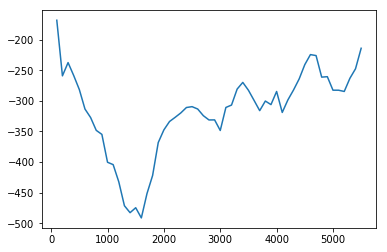

In [18]:
from pandas import ewma
iters,session_rewards=zip(*sorted(rewards.items(),key=lambda (k,v):k))
plt.plot(iters,ewma(np.array(session_rewards),span=10))

In [19]:
final_reward = pool.evaluate(n_games=10,save_path="./records",record_video=True)

print("average reward:",final_reward)

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./records/")))

for video_name in video_names:
    HTML("""
    <video width="640" height="480" controls>
      <source src="{}" type="video/mp4">
    </video>
    """.format("./records/"+video_name)) #this may or may not be _last_ video. Try other indices

[2018-02-02 23:47:29,715] Making new env: LunarLander-v2
[2018-02-02 23:47:29,725] Clearing 2 monitor files from previous run (because force=True was provided)
[2018-02-02 23:47:29,728] Starting new video recorder writing to /Users/maximdankovtsev/Developer/ml-mipt-part2/hw/HW5/records/openaigym.video.56.2487.video000000.mp4
[2018-02-02 23:47:33,029] Starting new video recorder writing to /Users/maximdankovtsev/Developer/ml-mipt-part2/hw/HW5/records/openaigym.video.56.2487.video000001.mp4


Episode finished after 168 timesteps with reward=-66.9489493822
Episode finished after 243 timesteps with reward=-132.725488259
Episode finished after 212 timesteps with reward=-167.846737751
Episode finished after 189 timesteps with reward=-56.784009607
Episode finished after 238 timesteps with reward=-173.311767428
Episode finished after 225 timesteps with reward=-152.199867131
Episode finished after 233 timesteps with reward=-102.060288603


[2018-02-02 23:47:38,568] Starting new video recorder writing to /Users/maximdankovtsev/Developer/ml-mipt-part2/hw/HW5/records/openaigym.video.56.2487.video000008.mp4


Episode finished after 204 timesteps with reward=-16.5843069481


[2018-02-02 23:47:42,242] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/maximdankovtsev/Developer/ml-mipt-part2/hw/HW5/records')


Episode finished after 199 timesteps with reward=-261.040989362
Episode finished after 171 timesteps with reward=-173.758615319
('average reward:', [-66.94894938223868, -132.7254882586081, -167.8467377509109, -56.78400960699836, -173.31176742760334, -152.1998671313281, -102.06028860307757, -16.58430694805722, -261.04098936198614, -173.75861531868625])
